# Hand-written digit classification by different classification methods
#### Version 2 (Sep 2020) / tested for python 3.7.6

### General information

***Goal:*** Implementation of different classification models and comparison of their performance in predicting the correct digit from given images containing hand-written digits.

***Note:*** In this current version I implemented 2 models: multiclass (OvR) logistic regression, and neural network. In the next versions I plan to add other classification models (SVM, kNN), and compare the performances between the models.

***Dataset:*** Images are taken from the MNIST handwritten digit database (loaded via sklearn.datasets)


***Logistic regression model parameters:***
- multi-class technique: One-Vs-Rest
- optimization algorithm: L-BFGS
- regularization method: L2/RIDGE

***Neural network model parameters:***
- model: Sequential (2 hidden layers x 64 units) 
- optimizer: Stochastic
- regulatization: Dropout layer (0.1)
- loss function: Categorical crossentropy

In [58]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams['figure.dpi'] = 100

In [59]:
# Data inspection functions:
############################

def display_data(array, example_width=None):
    """
    Plots images from array (rows=images, columns=pixels)
    :param array: images-array of m images (rows) x n pixels (cols)
    :param example_width: number of pixels in an image's row (optional)
    :return: display_array: matrix containing all images for visualization
    """
    [m, n] = array.shape
    try:
        example_height = int(n / example_width)
    except TypeError:
        example_width = int(round(math.sqrt(array.shape[1] - 1)))
        example_height = int(n / example_width)

    display_rows = math.floor(np.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    filler = 1
    display_array = - np.ones(
        (filler + display_rows * (example_height + filler), filler + display_cols * (example_width + filler)))

    curr_ex = 0
    for j in range(display_rows):
        for i in range(display_cols):
            if curr_ex + 1 > m:
                break
            max_val = max(abs(array[curr_ex, :]))

            row_start = filler + j * (example_height + filler)
            row_end = filler + j * (example_height + filler) + example_height
            col_start = filler + i * (example_width + filler)
            col_end = filler + i * (example_width + filler) + example_width

            display_array[row_start:row_end, col_start:col_end] = \
                np.reshape(array[curr_ex, :], (example_height, example_width)) / max_val

            curr_ex += 1

        if curr_ex + 1 > m:
            break

    plt.imshow(display_array, cmap='gray', vmin=-1, vmax=1)  # cmap=plt.cm.binary
    plt.axis('off')
    plt.show()

def classes_distrib(y_values, y_title):
    plt.figure(figsize=(6,3))
    sns.countplot(x=y_values, palette=['#86bf91'])
    plt.xlabel("Class")
    plt.title("Classes distribution: {} (n={})".format(y_title, len(y_values)))
    plt.ylabel("Frequency")
    plt.show()

    
# Performance evaluation functions (used to evaluate all models):
#################################################################

from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from IPython.display import display, clear_output
from collections import OrderedDict

y_scores = OrderedDict()  # will store the prediction probabilities of each model (to compare between the models)

def eval_accuracy(actual_y, predicted_y):  # Correct/Total
    return accuracy_score(actual_y, predicted_y)  # same as: np.mean(actual_y == predicted_y)

def confus_matr(actual_y, predicted_y):
    n_classes = len(np.unique(actual_y))
    cm = confusion_matrix(actual_y, predicted_y)
    cm_df = pd.DataFrame(cm)
    col_list = ['Predicted ' + str(i) for i in range(n_classes)]
    cm_df.columns = col_list
    indices = {i: 'Actual ' + str(i) for i in range(n_classes)}
    cm_df = cm_df.rename(index=indices)
    return cm_df

def create_recall_precision_scores(actual_y, predicted_y):
    performance_df = pd.DataFrame(np.unique(y_validate).astype(int), columns=['Classes'])
    performance_df['Recall'] = performance_df.apply(lambda row: measure_recall(row, actual_y, predicted_y), axis=1)
    performance_df['Precision'] = performance_df.apply(lambda row: measure_precision(row, actual_y, predicted_y), axis=1)
    return performance_df

def measure_recall(row, actual_y, predicted_y):
    result = (predicted_y[actual_y == row['Classes']] == row['Classes']).sum() / len(predicted_y[actual_y == row['Classes']])  # TP / (TP + FN)  ("recall", "sensitivity")
    return result

def measure_precision(row, actual_y, predicted_y):
    result = (predicted_y[actual_y == row['Classes']] == row['Classes']).sum() / (predicted_y == row['Classes']).sum()  # TP / (TP + FP)  ("precision", "positive predictive value")
    return result

def binarize_classes(y_values):  # transform target vector (examples x explicit value) to binarized matrix (examples x classes)
    y_binarized = label_binarize(y_values, classes=np.unique(y_values))
    return y_binarized

def precision_recall_curves(y_binarized, y_score):  # precision-recall AUC, grouped-by classes (including f1-scores areas)
    n_classes = y_binarized.shape[1]
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_binarized[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_binarized[:, i], y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(y[45] + 0.02, 1.05))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.title("Precision vs. Recall curve")
    plt.show()

def micro_avg_prec_recall(ax, y_binarized, y_score, model_name):  # A "micro-average": total precision-recall AUC across classes 
    # precision recall curve
    precision = dict()
    recall = dict()
    average_precision = dict()
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_binarized.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_binarized, y_score, average="micro")
    plt.step(recall['micro'], precision['micro'], where='post', label='{0}: AP={1:0.2f}'.format(model_name, average_precision["micro"]))
    plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))

def set_ax_params(ax):
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    return ax
    
def analyze_model_performance(actual_y, predicated_y, y_score, model_name):
    y_binarized = binarize_classes(actual_y)  
    
    # 1. accuracy score:
    print('Accuracy score, Model: {}'.format(model_name))
    model_accuracy = eval_accuracy(actual_y, predicated_y)
    print(str(round(model_accuracy * 100, 1)) + '\n'*2)

    # 2. confusion matrix:
    print('Confusion matrix, Model: {}'.format(model_name))
    cm_df = confus_matr(actual_y, predicated_y)
    display(cm_df)
    print('\n'*2)

    # 3. precision-recall scores per class
    print('Precision & recall scores for each class, Model: {}'.format(model_name))
    performance_df = create_recall_precision_scores(actual_y, predicated_y)
    display(performance_df)
    print('\n'*2)
    
    # 4. precision-recall curves by classes
    print('Precision-recall curves for each class, Model: {}'.format(model_name))
    precision_recall_curves(y_binarized, y_score)
    print('\n'*2)

    # 5. micro-avg. precision-recall curve
    fig, ax = plt.subplots()
    ax = set_ax_params(ax)
    print('Micro-averaged precision-recall curve, Model: {}'.format(model_name))
    micro_avg_prec_recall(ax, y_binarized, y_score, model_name)
    
def plt_training_progress(history, var_list):  # plot loss & accuracy for training & validation sets along training
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(np.sqrt(history[var_list[0]]), 'r', label='train')
    ax.plot(np.sqrt(history[var_list[1]]), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=10)
    ax.set_ylabel(r'Accuracy', fontsize=10)
    ax.legend()
    ax.tick_params(labelsize=10)

## 1. Load data

In [60]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, cache=True)  # takes about a min to load...
mnist.target = mnist.target.astype(np.int8)

## 2. Inspect data

### 2.1. Plot random images from the dataset

Labels of plotted images: [0 5 6 9 1 5 0 8 3 5 6 6 3 6 7 7 8 7 3 5 4 7 9 7 6]


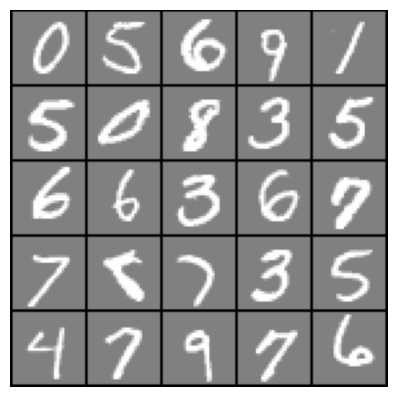

In [61]:
imgs_num = 25  # number of images to display
rand_imgs = np.random.permutation(mnist.data.shape[0])[0:imgs_num] 
print('Labels of plotted images: {}'.format(mnist.target[rand_imgs]))
display_data(mnist.data[rand_imgs, :])

### 2.2. Plot classes distribution (check if data is balanced)

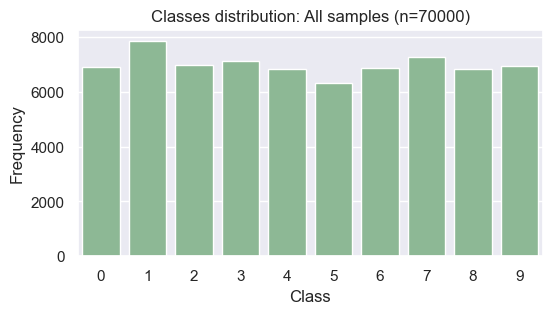

In [62]:
classes_distrib(mnist.target, 'All samples')

## 3. Data pre-processing

### 3.1. shuffle, normalize, split to train / validation / test subsets

In [63]:
# pre-training steps
data_mat = np.column_stack([mnist.target, mnist.data])
np.random.shuffle(data_mat)  # randomly shuffle the dataset
y = data_mat[:,0]
X = data_mat[:,1:]
X_norm = X / np.abs(X).max(axis=1).reshape(len(X),1)  # normalize (divide each image values by its max value)
X_train, X_validate, X_test = np.split(X_norm, [int(len(X_norm)*0.6), int(len(X_norm)*0.8)])  # split X to train/val/test arrays (0.6/0.2/0.2 ratio)
y_train, y_validate, y_test = np.split(y, [int(len(y)*0.6), int(len(y)*0.8)])  # split y to similar groups as X

### 3.2. Plot classes distribution of the validation set
(to check if data is balanced - relevant for preformance evaluation stage, to decide between micro-average and macro-average)

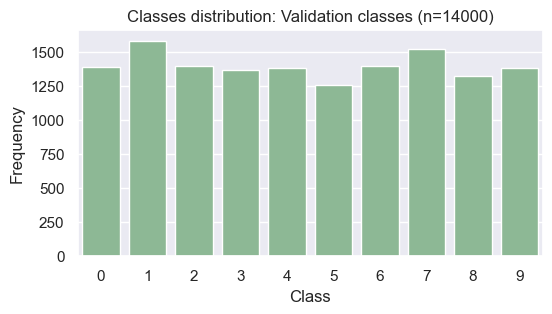

In [64]:
classes_distrib(y_validate.astype(int), 'Validation classes')  # show once that the validation classes are balanced - for the micro-avg curve

## 4. Train, predict and evaluate different classification models

### 4.1. Logistic regression

#### 4.1.1. Train model
(~2 min. on a reasonable laptop)

In [65]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500, random_state=0, multi_class='ovr').fit(X_train, y_train)

#### 4.1.2. Generate predictions using the validation set

In [66]:
y_predicted = clf.predict(X_validate)
y_score_logit = clf.predict_proba(X_validate)
y_scores['logit'] = y_score_logit

#### 4.1.3 Performance evaluation

Accuracy score, Model: Logistic regression
91.6


Confusion matrix, Model: Logistic regression


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,1350,0,4,4,4,9,8,4,6,0
Actual 1,1,1544,11,3,1,5,3,4,10,1
Actual 2,9,15,1242,27,16,8,16,19,41,5
Actual 3,6,7,29,1224,1,47,5,9,24,15
Actual 4,6,7,12,1,1273,2,10,6,15,49
Actual 5,10,11,9,50,18,1083,21,5,39,12
Actual 6,8,3,12,0,6,17,1341,1,6,1
Actual 7,7,7,17,11,17,2,1,1399,5,57
Actual 8,7,32,12,45,12,42,6,9,1137,21
Actual 9,7,8,3,23,51,10,1,42,14,1224





Precision & recall scores for each class, Model: Logistic regression


,Classes,Recall,Precision
0,0,0.971922,0.956768
1,1,0.975363,0.944920
2,2,0.888412,0.919319
3,3,0.895391,0.881844
4,4,0.921796,0.909936
5,5,0.860890,0.884082
6,6,0.961290,0.949717
7,7,0.918582,0.933912
8,8,0.859410,0.876638
9,9,0.885033,0.883755





Precision-recall curves for each class, Model: Logistic regression


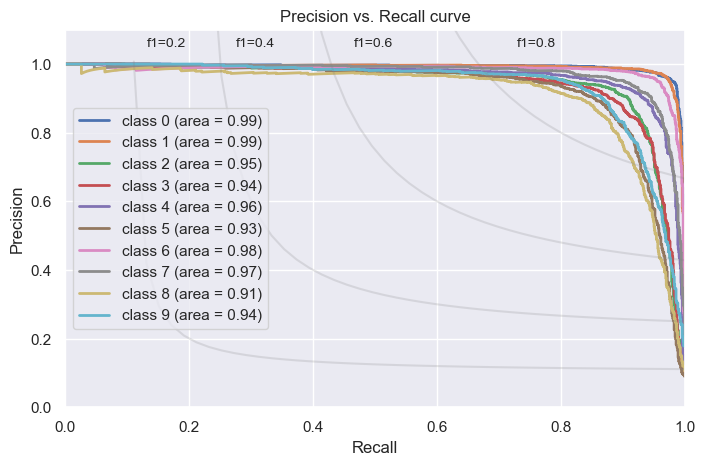




Micro-averaged precision-recall curve, Model: Logistic regression


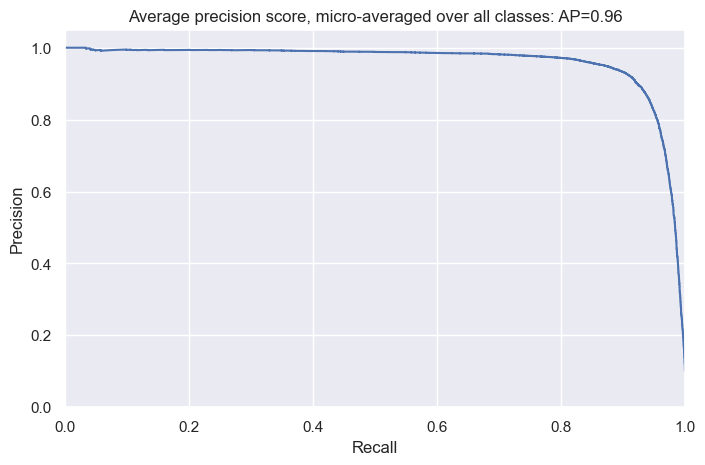

In [67]:
analyze_model_performance(y_validate, y_predicted, y_score_logit, 'Logistic regression')

### 4.2. Neural Network

In [68]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras.optimizers import SGD
# from keras.optimizers import RMSprop  # will be implemented in a later version
# from keras.callbacks import LearningRateScheduler  # will be implemented in a later version
# from keras.callbacks import History  # will be implemented in a later version

print('TensorFlow version: {}'.format(tf.__version__)) 
print('Implemented Keras API version: {}'.format(tf.keras.__version__))

TensorFlow version: 2.1.0
Implemented Keras API version: 2.2.4-tf


Using TensorFlow backend.


In [69]:
# set hyper-params & optimizer action mode:
epochs=60
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# define network topology:
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

lr_model = Sequential()
lr_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', 
                input_dim = input_dim)) 
lr_model.add(Dropout(0.1))
lr_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# compile model
lr_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

#### 4.2.1. Train model
(~10 min. on a reasonable laptop for the following topology & hyperparams)

Train on 42000 samples, validate on 14000 samples
Epoch 1/60
42000/42000 [==============================] - 11s 259us/step - loss: 0.3738 - acc: 0.8877 - val_loss: 0.1676 - val_acc: 0.9499
Epoch 2/60
42000/42000 [==============================] - 11s 256us/step - loss: 0.1780 - acc: 0.9470 - val_loss: 0.1341 - val_acc: 0.9592
Epoch 3/60
42000/42000 [==============================] - 11s 253us/step - loss: 0.1480 - acc: 0.9559 - val_loss: 0.1268 - val_acc: 0.9627
Epoch 4/60
42000/42000 [==============================] - 11s 255us/step - loss: 0.1361 - acc: 0.9588 - val_loss: 0.1151 - val_acc: 0.9649
Epoch 5/60
42000/42000 [==============================] - 11s 253us/step - loss: 0.1225 - acc: 0.9630 - val_loss: 0.1119 - val_acc: 0.9654
Epoch 6/60
42000/42000 [==============================] - 11s 251us/step - loss: 0.1168 - acc: 0.9652 - val_loss: 0.1087 - val_acc: 0.9671
Epoch 7/60
42000/42000 [==============================] - 11s 255us/step - loss: 0.1164 - acc: 0.9646 - val_loss: 0.

42000/42000 [==============================] - 11s 252us/step - loss: 0.0744 - acc: 0.9775 - val_loss: 0.0928 - val_acc: 0.9716
Epoch 60/60
42000/42000 [==============================] - 11s 251us/step - loss: 0.0746 - acc: 0.9775 - val_loss: 0.0930 - val_acc: 0.9719
Wall time: 10min 56s


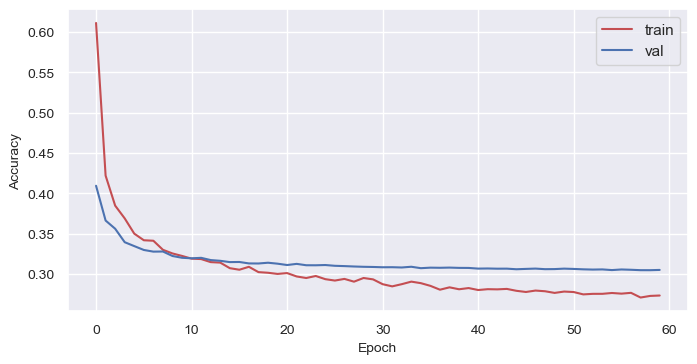

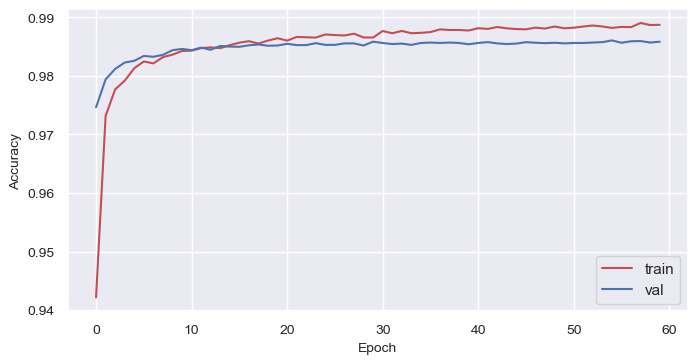

In [70]:
%%time
# Fit the model
batch_size = int(input_dim/100)

y_train_binarized = binarize_classes(y_train)
y_validate_binarized = binarize_classes(y_validate)
lr_model_history = lr_model.fit(X_train, y_train_binarized,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_validate, y_validate_binarized))

# plot progress along training epochs (loss & accuracy for training & validation subsets)
measures = ['loss', 'val_loss', 'acc', 'val_acc']
for m in [0,2]:
    plt_training_progress(lr_model_history.history, measures[m:m+2])

#### 4.2.2. Generate predictions using the validation set

In [71]:
y_predicted = lr_model.predict_classes(X_validate)
y_score_nn = lr_model.predict_proba(X_validate)
y_scores['neural_net'] = y_score_nn

#### 4.2.3 Performance evaluation

Accuracy score, Model: Neural network
97.2


Confusion matrix, Model: Neural network


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,1366,0,5,1,1,3,6,2,3,2
Actual 1,1,1563,10,1,1,1,0,2,3,1
Actual 2,1,6,1356,5,6,1,2,11,9,1
Actual 3,0,1,15,1324,0,14,0,4,6,3
Actual 4,1,3,8,0,1343,1,5,4,1,15
Actual 5,1,3,1,8,1,1222,5,4,10,3
Actual 6,9,1,5,0,4,6,1366,0,4,0
Actual 7,1,4,10,6,5,1,1,1479,2,14
Actual 8,8,6,5,13,3,11,3,2,1262,10
Actual 9,4,0,0,18,20,3,1,10,2,1325





Precision & recall scores for each class, Model: Neural network


,Classes,Recall,Precision
0,0,0.983441,0.981322
1,1,0.987366,0.984877
2,2,0.969957,0.958304
3,3,0.968544,0.962209
4,4,0.972484,0.970376
5,5,0.971383,0.967538
6,6,0.979211,0.983441
7,7,0.971110,0.974308
8,8,0.953893,0.969278
9,9,0.958062,0.964338





Precision-recall curves for each class, Model: Neural network


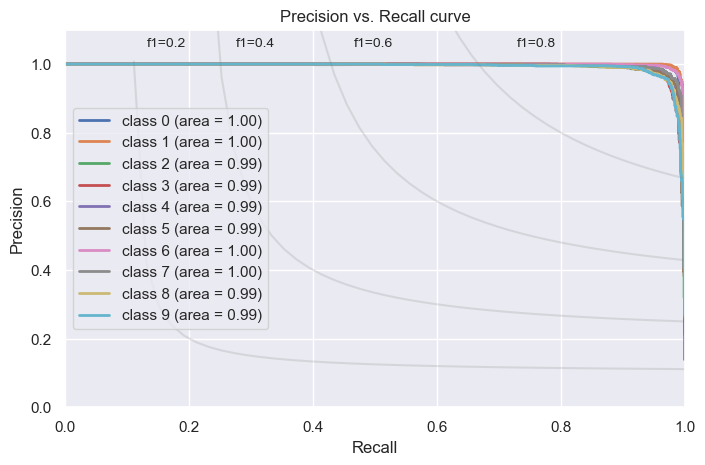




Micro-averaged precision-recall curve, Model: Neural network


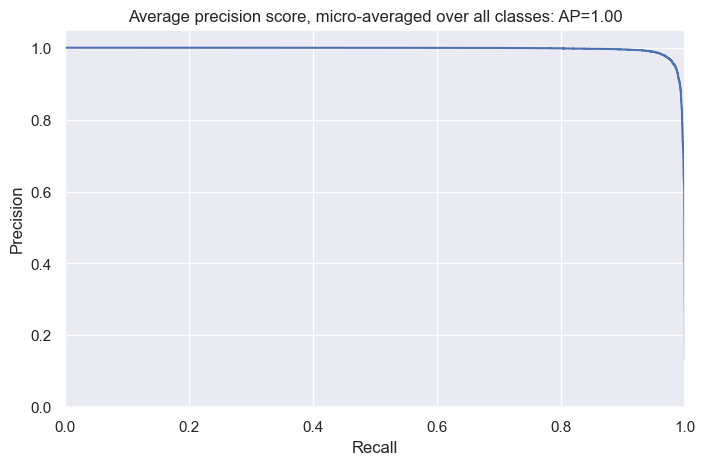

In [72]:
analyze_model_performance(y_validate, y_predicted, y_score_nn, 'Neural network')

## 5. Comparing between classification models

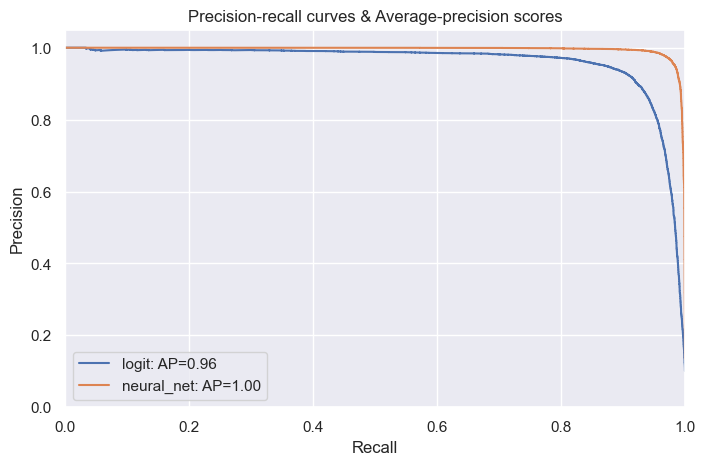

In [73]:
# plot precision-recall curve for each model
fig, ax = plt.subplots()
ax = set_ax_params(ax)
for i in range(len(list(y_scores.items()))):  
    model_name, y_score = list(y_scores.items())[i][0], list(y_scores.items())[i][1]
    micro_avg_prec_recall(ax, y_validate_binarized, y_score, model_name)
plt.title('Precision-recall curves & Average-precision scores')  
plt.legend(loc="best")
plt.show()

### Inspecting false negatives for a chosen class

False negatives for class=1:
[2 3 8 9 7 2 2 4 7 2 2 8 5 8 2 2 0 2 2 2]


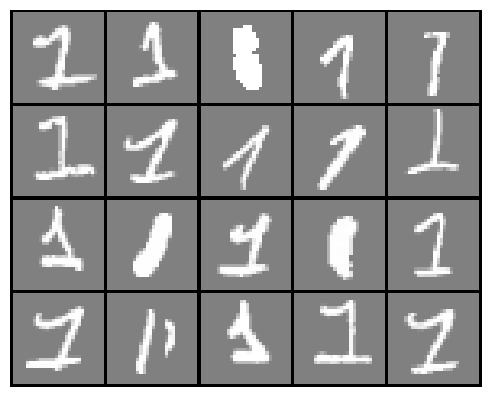

In [74]:
inspected_class = 1
false_negatives = y_predicted[y_validate == inspected_class] != inspected_class
print('False negatives for class={}:'.format(inspected_class))
print(y_predicted[y_validate == inspected_class][false_negatives].astype(int))
display_data(X_validate[y_validate == inspected_class][false_negatives]) 

## Next steps following the current version:
- imrovement of models already implemented (logistic regression, neural network), based on validation outputs
- implement other classification models such as kNN and SVM w/wo gaussian kernel
- compare algorithms performance